# 공급망 최적화

In [322]:
from internal.hprint import hprint
import pandas	as pd
import numpy as	np
import matplotlib.pyplot as	plt
from	sklearn.preprocessing	import	StandardScaler
import tensorflow	as	tf
from tensorflow import keras
import os
import shutil
from sklearn.metrics import mean_absolute_error

# 데이터 불러오기
data = pd.read_excel('data.xls')

# 94번 제품의 데이터만 추출
data_94 = data[(data["Part Number"]=='Part 94')]
data_94.reset_index(drop=True, inplace=True)

In [323]:
# 누락 데이터 확인
data_94.isna().sum()

# 필요 없는 열 제거
coloumn = ['D일 투입예정 수량(D일계획)',	'D+1일 투입예정 수량(Total)',	'D+2일 투입예정 수량(Total)',	'D+3일 투입예정 수량(Total)',	'D+4일 투입예정 수량(Total)',	'D+5일 투입예정 수량', 'D+6일 투입예정 수량',	'D+7일 투입예정 수량', 'D+8일 투입예정 수량',	'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량', 'D+12일 투입예정 수량', 'CRET_TIME']
data_94 = data_94.loc[:, coloumn]

# 시간 데이터 변환
data_94['CRET_TIME'] = pd.to_datetime(data_94['CRET_TIME'], format="%Y%m%d%H%M")

# 기록 일자에서 마지막 시각에 기록된 데이터만 추출
data_94 = data_94.groupby(by=[
  data_94['CRET_TIME'].dt.year,
  data_94['CRET_TIME'].dt.month,
  data_94['CRET_TIME'].dt.day]).last()
data_94.reset_index(drop=True, inplace=True)

data_94.head()

,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(Total),D+2일 투입예정 수량(Total),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량,CRET_TIME
0,42,32,30,30,30,38,0,30,30,30,30,30,0,2021-09-13 18:30:00
1,40,30,30,30,50,45,30,30,30,30,30,0,0,2021-09-14 17:30:00
2,40,30,30,47,43,51,0,0,0,30,30,0,30,2021-09-15 16:33:00
3,47,30,0,53,42,39,0,0,30,30,0,30,30,2021-09-16 17:06:00
4,46,30,30,44,37,51,0,30,30,0,30,30,30,2021-09-17 06:32:00


In [324]:
# 데이터 당일 예상 수량과 당일+ 수량이 같은 행에 걸치게 재배치
corr_data_94 = pd.concat([
  data_94.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
  data_94.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
  data_94.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
  data_94.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
  data_94.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
  data_94.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
  data_94.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)],
axis=1)

# 상관계수 확인
corr_data_94.corr().head(2)


,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(Total),D+2일 투입예정 수량(Total),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량
D일 투입예정 수량(D일계획),1.000000,0.651721,0.408578,0.393761,0.136667,0.388251,0.018768,0.127412,0.246102,0.024242,0.215673,0.103277,0.081598
D+1일 투입예정 수량(Total),0.651721,1.000000,0.567057,0.007026,-0.052853,-0.074226,-0.028867,0.114627,0.345470,0.079831,0.286655,0.184163,0.178313


In [325]:
# 데이터 선정 (상관계수가 높은 3일 이내의 데이터)
data_94 = data_94.loc[:, [
  'D일 투입예정 수량(D일계획)',
  'D+1일 투입예정 수량(Total)',
  'D+2일 투입예정 수량(Total)',	
  'D+3일 투입예정 수량(Total)']]
data_94.reset_index(drop=True, inplace=True)
data_94.head()

,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(Total),D+2일 투입예정 수량(Total),D+3일 투입예정 수량(Total)
0,42,32,30,30
1,40,30,30,30
2,40,30,30,47
3,47,30,0,53
4,46,30,30,44


In [326]:
#	사용자 정의 함수 만들기
def	to_timeseries_data(data):
  #	data는 원본	tabular	데이터

  output_len = len(data)-3
  n_feature	=	data.shape[-1]	#	=4
  inputs = np.zeros((output_len, 3, n_feature))	#	(N,3,4)
  targets = np.zeros((output_len,))	#	(N,)
  for	i	in range(output_len):
    inputs[i]	= data.iloc[i:i+3, :]
    targets[i] = data.iloc[i+3,	0]
  return inputs, targets

#	사용자 정의 함수 적용
X_94,	y_94 = to_timeseries_data(data_94)
print("X의 형태: ",X_94.shape)
print("y의 형태: ",y_94.shape)

X의 형태:  (46, 3, 4)
y의 형태:  (46,)


In [327]:
# 데이터 분리
X_train_94,	X_val_94,	X_test_94	=	np.split(X_94, [int(0.7*len(X_94)), int(0.8*len(X_94))])	
y_train_94,	y_val_94,	y_test_94	=	np.split(y_94, [int(0.7*len(y_94)), int(0.8*len(y_94))])

#	데이터 분리 및 정규화(평균 0,	표준편차	1)
Xscaler_94 = StandardScaler()
X_train_94 = Xscaler_94.fit_transform(X_train_94.reshape(-1,	X_train_94.shape[-1])).reshape(X_train_94.shape)
X_val_94 = Xscaler_94.transform(X_val_94.reshape(-1,	X_val_94.shape[-1])).reshape(X_val_94.shape)
X_test_94 = Xscaler_94.transform(X_test_94.reshape(-1,	X_test_94.shape[-1])).reshape(X_test_94.shape)
yscaler_94 = StandardScaler()
y_train_94 = yscaler_94.fit_transform(y_train_94.reshape(-1,1))
y_val_94 = yscaler_94.transform(y_val_94.reshape(-1,1))
y_test_94 = yscaler_94.transform(y_test_94.reshape(-1,1))


In [328]:
# 분석 모델 구축
tf.random.set_seed(42)
model	=	keras.Sequential(
  [
    keras.layers.LSTM(8, dropout=0.2,	activation='relu', input_shape=(3,4),	return_sequences=True),
    keras.layers.LSTM(8, dropout=0.2,	activation='relu'),
    keras.layers.Dense(1,	activation='linear')
  ]
)
model.summary()

c:\ML-Learn\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 3, 8)           │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969 (3.79 KB)

 Trainable params: 969 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [329]:
# 모델 학습
if os.path.isdir('./model'):
  shutil.rmtree('./model')

model_path = './model/{epoch:02d}-{val_loss:.4f}.keras'
model.compile(optimizer='adam',	loss='mae')
history	=	model.fit(
  X_train_94,	
  y_train_94,	
  epochs=100,	
  batch_size=4,	
  validation_data=(X_val_94, y_val_94),
  callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_loss',	patience=15),
    keras.callbacks.ModelCheckpoint(filepath=model_path,	monitor='val_loss',	verbose=0,	save_best_only=True)
  ])


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.7831 - val_loss: 0.6614
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7761 - val_loss: 0.6602
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7699 - val_loss: 0.6586
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7765 - val_loss: 0.6570
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7617 - val_loss: 0.6556
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7829 - val_loss: 0.6540
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7769 - val_loss: 0.6520
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7691 - val_loss: 0.6506
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7509 - val_loss: 0.6486
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7403 - val_loss: 0.6454
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7274 - val_loss: 0.6417
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7276 - val_lo

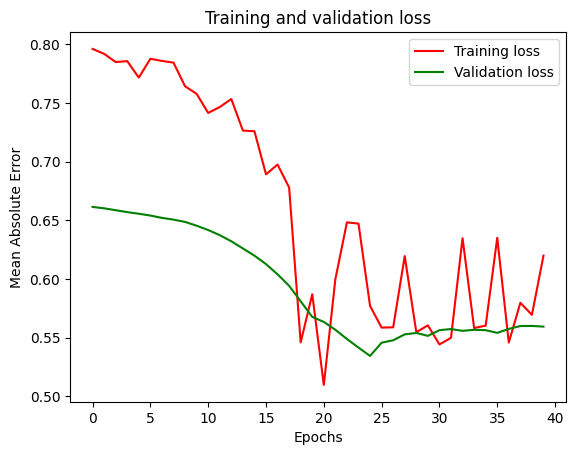

In [ ]:
# 학습 결과 시각화 (손실함수)
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch
plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step - loss: 1.1137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


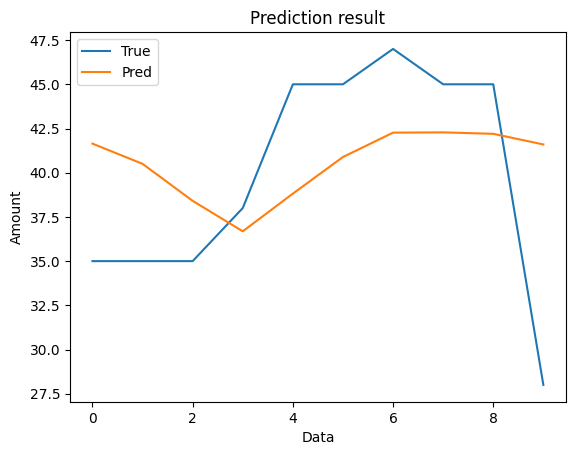


평균 절대 오차(MAE):

5.1016395568847654


In [331]:
# 모델 예측 및 평가
best_model_name = os.listdir('./model')[-1]
best_model = keras.models.load_model(f'./model/{best_model_name}')
best_model.evaluate(X_test_94, y_test_94) # MAE

# 예측 결과
y_pred_94 = best_model.predict(X_test_94)

# 예측 결과 역정규화
y_pred_94_inv	=	yscaler_94.inverse_transform(y_pred_94)
y_test_94_inv	=	yscaler_94.inverse_transform(y_test_94)

# MAE 계산
mae = mean_absolute_error(y_test_94_inv, y_pred_94_inv)

# 예측 결과 시각화
plt.figure()
plt.plot(y_test_94_inv, label='True')
plt.plot(y_pred_94_inv, label='Pred')
plt.title('Prediction result')
plt.xlabel('Data')
plt.ylabel('Amount')
plt.legend()
plt.show()

hprint("평균 절대 오차(MAE):")
print(mae)